# **タイタニック_災害からの機械学習**
(Titanic - Machine Learning from Disaster)

# 参考資料
**書籍**


**Kaggle**


**自分で作成したファイル**
- モース硬度データセットを使用した回帰
- 生体信号を使用した喫煙者の状態のバイナリ予測
- ソフトウェア欠陥データセットによるバイナリ分類
- 肝硬変の転帰の多クラス予測

## 概要
1. 目的：Titanic号の乗客が最終的に亡くなったかどうかを予測する
2. 目次:
    * ライブラリ・データセットのインポート
    * EDA
3. データセット:
    *
4. 目的変数： 'Survived'(int64)

### 各特徴量の日本語訳

変数 |定義 |備考  
---|---|---
Survived |死亡したかどうか |0 = No, 1 = Yes
Pclass |チケットのクラス |1 = 1st, 2 = 2nd, 3 = 3rd
Name |名前 |
Sex |性別 |
Age	|年齢 |
SibSp |乗船していた兄弟姉妹・配偶者の数	|
Parch |乗船していた親・子供の数	|
Ticket |チケット番号	|
Fare |チケット料金	|
Cabin |キャビン番号	|
embarked |乗船した港	|C = Cherbourg, Q = Queenstown, S = Southampton

## 評価指標: 正解率(accuracy)

# ライブラリ・データセットのインポート

In [1]:
!pip install sweetviz
!pip install category_encoders

  Obtaining dependency information for sweetviz from https://files.pythonhosted.org/packages/89/50/8d3f7ca820267a38b42c64778db0f186d85cec6e3f0c5210eab9c16e783f/sweetviz-2.3.1-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 55.2 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import norm, skew

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
from IPython.display import display
import sweetviz as sv

import warnings; warnings.filterwarnings("ignore")

# pd.set_option('display.max_columns', 30)
pd.options.display.max_columns = 30
pd.options.display.max_rows = 50
plt.style.use('ggplot')

In [3]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
import missingno as msno

# 敵対性の検証で用いる
from category_encoders import OneHotEncoder
from sklearn.model_selection import  StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier

## 実行時間を調べるために使う

In [4]:
import datetime
import time
import math

start_time = time.time()

def changeHMS(s):
    h = math.floor(s / 3600)
    if h > 0:
        s = s - h * 3600
        indi_h = str(h) + 'h'
    else:
        indi_h = ''
    m = math.floor(s / 60)
    if m > 0:
        indi_m = str(m) + 'm'
    else:
        indi_m = ''
    s = math.floor(s % 60)
    time = indi_h + indi_m + str(s) + 's'
    return time

In [5]:
FILE_PATH = '/kaggle/input/titanic/'
OUTPUT_DIR = '/kaggle/working/'

train = pd.read_csv(FILE_PATH + 'train.csv')
test = pd.read_csv(FILE_PATH + 'test.csv')

## id と目的変数の分割

In [6]:
train_id = train['PassengerId']
train.drop('PassengerId', axis=1, inplace=True)

test_id = test['PassengerId']
test.drop('PassengerId', axis=1, inplace=True)

target = train['Survived']

target_name = str(train.iloc[:, [0]].columns.tolist()) # カラム数-2の値が目的変数
print(target_name)

['Survived']


## データ(DataFrame)の構成を調べる

In [7]:
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:
test.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [9]:
print('train: ')
print(train.shape)
print(train.info())
print('\n')
print('test: ')
print(test.shape)
print(test.info())

train: 
(891, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 76.7+ KB
None


test: 
(418, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non

In [10]:
train_columns = train.columns
train_index = train.index
train_data = train.values # values

test_columns = test.columns
test_index = test.index
test_data = test.values # values

print('train: ')
print(type(train_columns))
print(type(train_index))
print(type(train_data))
print('\n')
print('test: ')
print(type(test_columns))
print(type(test_index))
print(type(test_data))

train: 
<class 'pandas.core.indexes.base.Index'>
<class 'pandas.core.indexes.range.RangeIndex'>
<class 'numpy.ndarray'>


test: 
<class 'pandas.core.indexes.base.Index'>
<class 'pandas.core.indexes.range.RangeIndex'>
<class 'numpy.ndarray'>


In [11]:
with pd.option_context('display.max_rows', 8):
    display(train)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
...,...,...,...,...,...,...,...,...,...,...,...
887,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C
890,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.7500,NaN,Q


In [12]:
with pd.option_context('display.max_rows', 8):
    display(test)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
...,...,...,...,...,...,...,...,...,...,...
414,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S
417,3,"Peter, Master. Michael J",male,NaN,1,1,2668,22.3583,NaN,C


## データ型を理解する

In [13]:
print('train: ')
print(train.dtypes)
print(train.dtypes.value_counts())
print('\n')
print('test: ')
print(test.dtypes)
print(test.dtypes.value_counts())

train: 
Survived      int64
Pclass        int64
Name         object
Sex          object
Age         float64
SibSp         int64
Parch         int64
Ticket       object
Fare        float64
Cabin        object
Embarked     object
dtype: object
object     5
int64      4
float64    2
Name: count, dtype: int64


test: 
Pclass        int64
Name         object
Sex          object
Age         float64
SibSp         int64
Parch         int64
Ticket       object
Fare        float64
Cabin        object
Embarked     object
dtype: object
object     5
int64      3
float64    2
Name: count, dtype: int64


In [14]:
# 説明変数をデータ型ごとに代入する
numerical_features = test._get_numeric_data().columns
categorical_features = test.drop(numerical_features, axis=1).columns
numerical_features, categorical_features

(Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object'),
 Index(['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'], dtype='object'))

# EDA(探索的データ分析)

What's your EDA?  
**EDA(探索的データ分析)**: データセットに適宜前処理を施しつつ様々な統計量を抽出して可視化し、そこに内在する特性・パターン・偏りについて探索的に仮説立案・検証を繰り返して分析すること

## 要約統計量

In [15]:
train.describe().T \
.style.bar(subset=['mean'], color=px.colors.qualitative.G10[0]) \
.background_gradient(subset=['std'], cmap='Greens') \
.background_gradient(subset=['50%'], cmap='BuGn')

,count,mean,std,min,25%,50%,75%,max
Survived,891.000000,0.383838,0.486592,0.000000,0.000000,0.000000,1.000000,1.000000
Pclass,891.000000,2.308642,0.836071,1.000000,2.000000,3.000000,3.000000,3.000000
Age,714.000000,29.699118,14.526497,0.420000,20.125000,28.000000,38.000000,80.000000
SibSp,891.000000,0.523008,1.102743,0.000000,0.000000,0.000000,1.000000,8.000000
Parch,891.000000,0.381594,0.806057,0.000000,0.000000,0.000000,0.000000,6.000000
Fare,891.000000,32.204208,49.693429,0.000000,7.910400,14.454200,31.000000,512.329200


In [16]:
test.describe().T \
.style.bar(subset=['mean'], color=px.colors.qualitative.G10[0]) \
.background_gradient(subset=['std'], cmap='Greens') \
.background_gradient(subset=['50%'], cmap='BuGn')

,count,mean,std,min,25%,50%,75%,max
Pclass,418.000000,2.265550,0.841838,1.000000,1.000000,3.000000,3.000000,3.000000
Age,332.000000,30.272590,14.181209,0.170000,21.000000,27.000000,39.000000,76.000000
SibSp,418.000000,0.447368,0.896760,0.000000,0.000000,0.000000,1.000000,8.000000
Parch,418.000000,0.392344,0.981429,0.000000,0.000000,0.000000,0.000000,9.000000
Fare,417.000000,35.627188,55.907576,0.000000,7.895800,14.454200,31.500000,512.329200


In [17]:
desc_train = pd.DataFrame(index=list(train))
desc_train['count'] = train.count()
desc_train['nunique'] = train.nunique()
desc_train['%unique'] = desc_train['nunique'] / len(train) * 100
desc_train['null'] = train.isnull().sum()
desc_train['type'] = train.dtypes
desc_train = pd.concat([desc_train, train.describe().T], axis=1)
desc_train

,count,nunique,%unique,null,type,count,mean,std,min,25%,50%,75%,max
Survived,891,2,0.224467,0,int64,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891,3,0.336700,0,int64,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Name,891,891,100.000000,0,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sex,891,2,0.224467,0,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,714,88,9.876543,177,float64,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891,7,0.785634,0,int64,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891,7,0.785634,0,int64,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Ticket,891,681,76.430976,0,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fare,891,248,27.833895,0,float64,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292
Cabin,204,147,16.498316,687,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
desc_test = pd.DataFrame(index=list(test))
desc_test['count'] = test.count()
desc_test['nunique'] = test.nunique()
desc_test['%unique'] = desc_test['nunique'] / len(test) * 100
desc_test['null'] = test.isnull().sum()
desc_test['type'] = test.dtypes
desc_test = pd.concat([desc_test, test.describe().T], axis=1)
desc_test

,count,nunique,%unique,null,type,count,mean,std,min,25%,50%,75%,max
Pclass,418,3,0.717703,0,int64,418.0,2.265550,0.841838,1.00,1.0000,3.0000,3.0,3.0000
Name,418,418,100.000000,0,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sex,418,2,0.478469,0,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,332,79,18.899522,86,float64,332.0,30.272590,14.181209,0.17,21.0000,27.0000,39.0,76.0000
SibSp,418,7,1.674641,0,int64,418.0,0.447368,0.896760,0.00,0.0000,0.0000,1.0,8.0000
Parch,418,8,1.913876,0,int64,418.0,0.392344,0.981429,0.00,0.0000,0.0000,0.0,9.0000
Ticket,418,363,86.842105,0,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fare,417,169,40.430622,1,float64,417.0,35.627188,55.907576,0.00,7.8958,14.4542,31.5,512.3292
Cabin,91,76,18.181818,327,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Embarked,418,3,0.717703,0,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
# 特定の次元方向についての分散
print('train: ')
print(np.var(train[numerical_features], axis=0))
print('\n')
print('test: ')
print(np.var(test[numerical_features], axis=0))

train: 
Pclass       0.698231
Age        210.723580
SibSp        1.214678
Parch        0.648999
Fare      2466.665312
dtype: float64


test: 
Pclass       0.706995
Age        200.500952
SibSp        0.802254
Parch        0.960898
Fare      3118.161494
dtype: float64


### 変動係数

変動係数は、標準偏差を平均値で割った値
* スケールに依存せず、比較できるようになる

In [20]:
train[numerical_features].std() / train[numerical_features].mean()

Pclass    0.362149
Age       0.489122
SibSp     2.108464
Parch     2.112344
Fare      1.543073
dtype: float64

## 尖度（せんど）と歪度（わいど）

- 分布が正規分布からどれだけ歪んでいるかを表す統計量で、左右対称性を示す指標のこと
- 分布が正規分布からどれだけ尖っているかを表す統計量で、山の尖り度と裾の広がり度

In [21]:
print('train: ')
print(train[numerical_features].kurtosis())
print('\n')
print('test: ')
print(test[numerical_features].kurtosis())

train: 
Pclass    -1.280015
Age        0.178274
SibSp     17.880420
Parch      9.778125
Fare      33.398141
dtype: float64


test: 
Pclass    -1.382666
Age        0.083783
SibSp     26.498712
Parch     31.412513
Fare      17.921595
dtype: float64


### 目的変数の尖度と歪度

In [22]:
# skewness and kurtosis
print("尖度: %f" % target.skew())
print("歪度: %f" % target.kurt())

尖度: 0.478523
歪度: -1.775005


## 欠損値

In [23]:
print('train: ')
print(train.isna().sum().sort_values(ascending=False) / train.shape[0] * 100)
print('\n')
print(train.isnull().sum())
print('\n' * 2)
print('test: ')
print(test.isna().sum().sort_values(ascending=False) / train.shape[0] * 100)
print('\n')
print(test.isnull().sum())

train: 
Cabin       77.104377
Age         19.865320
Embarked     0.224467
Survived     0.000000
Pclass       0.000000
Name         0.000000
Sex          0.000000
SibSp        0.000000
Parch        0.000000
Ticket       0.000000
Fare         0.000000
dtype: float64


Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64



test: 
Cabin       36.700337
Age          9.652076
Fare         0.112233
Pclass       0.000000
Name         0.000000
Sex          0.000000
SibSp        0.000000
Parch        0.000000
Ticket       0.000000
Embarked     0.000000
dtype: float64


Pclass        0
Name          0
Sex           0
Age          86
SibSp         0
Parch         0
Ticket        0
Fare          1
Cabin       327
Embarked      0
dtype: int64


Axes(0.125,0.11;0.698618x0.77)
Axes(0.125,0.11;0.698618x0.77)


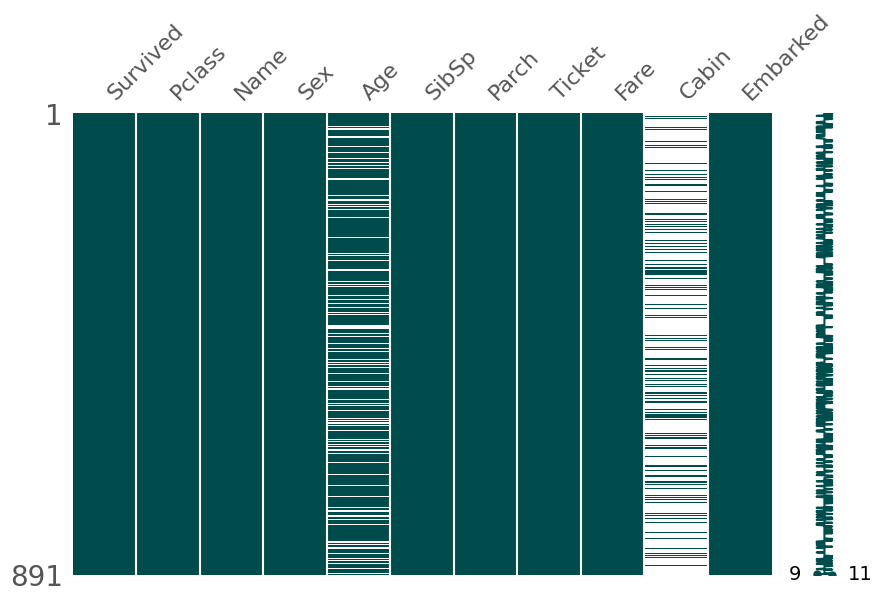

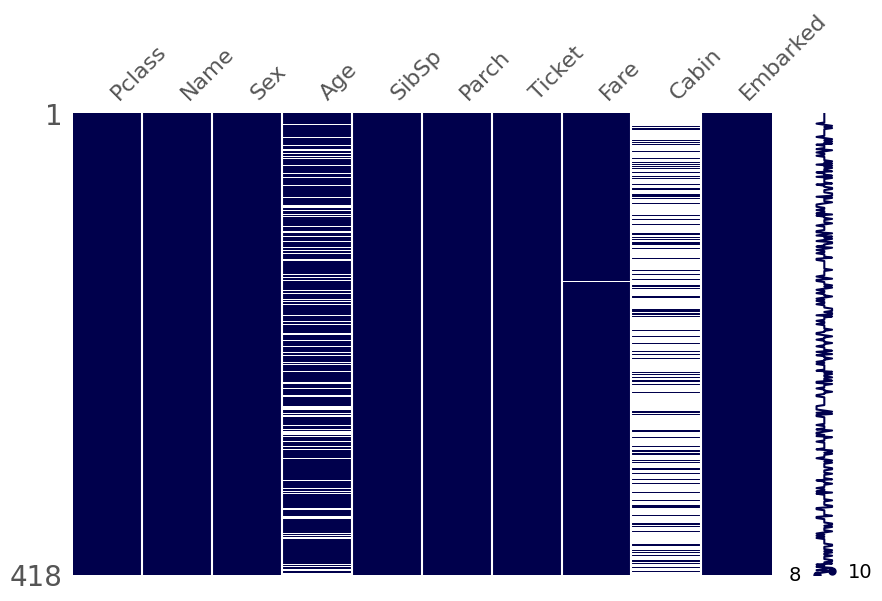

In [24]:
# 欠損値の有無を可視化する
print(msno.matrix(df=train, figsize=(10, 6), color=(0, .3, .3)))
print(msno.matrix(df=test, figsize=(10, 6), color=(0, 0, .3)))

欠損値のあるカラム
* train, test: 'Cabin', 'Age'
* train: 'Embarked'
* test: 'Fare'

## 重複データ

In [25]:
total = pd.concat([train.drop('Survived', axis=1), test], axis=0)
total.duplicated().sum()

0

## カラムごとのユニークな値を調べる

In [26]:
train[train.columns].nunique().sort_values(ascending=True)

Survived      2
Sex           2
Pclass        3
Embarked      3
SibSp         7
Parch         7
Age          88
Cabin       147
Fare        248
Ticket      681
Name        891
dtype: int64

* 'Name', 'Ticket'が特に種類が多い
* その次に'Fare', 'Cabin'も注目したい

## データセットのプロット（分布）

### 密度関数（ヒストグラム）

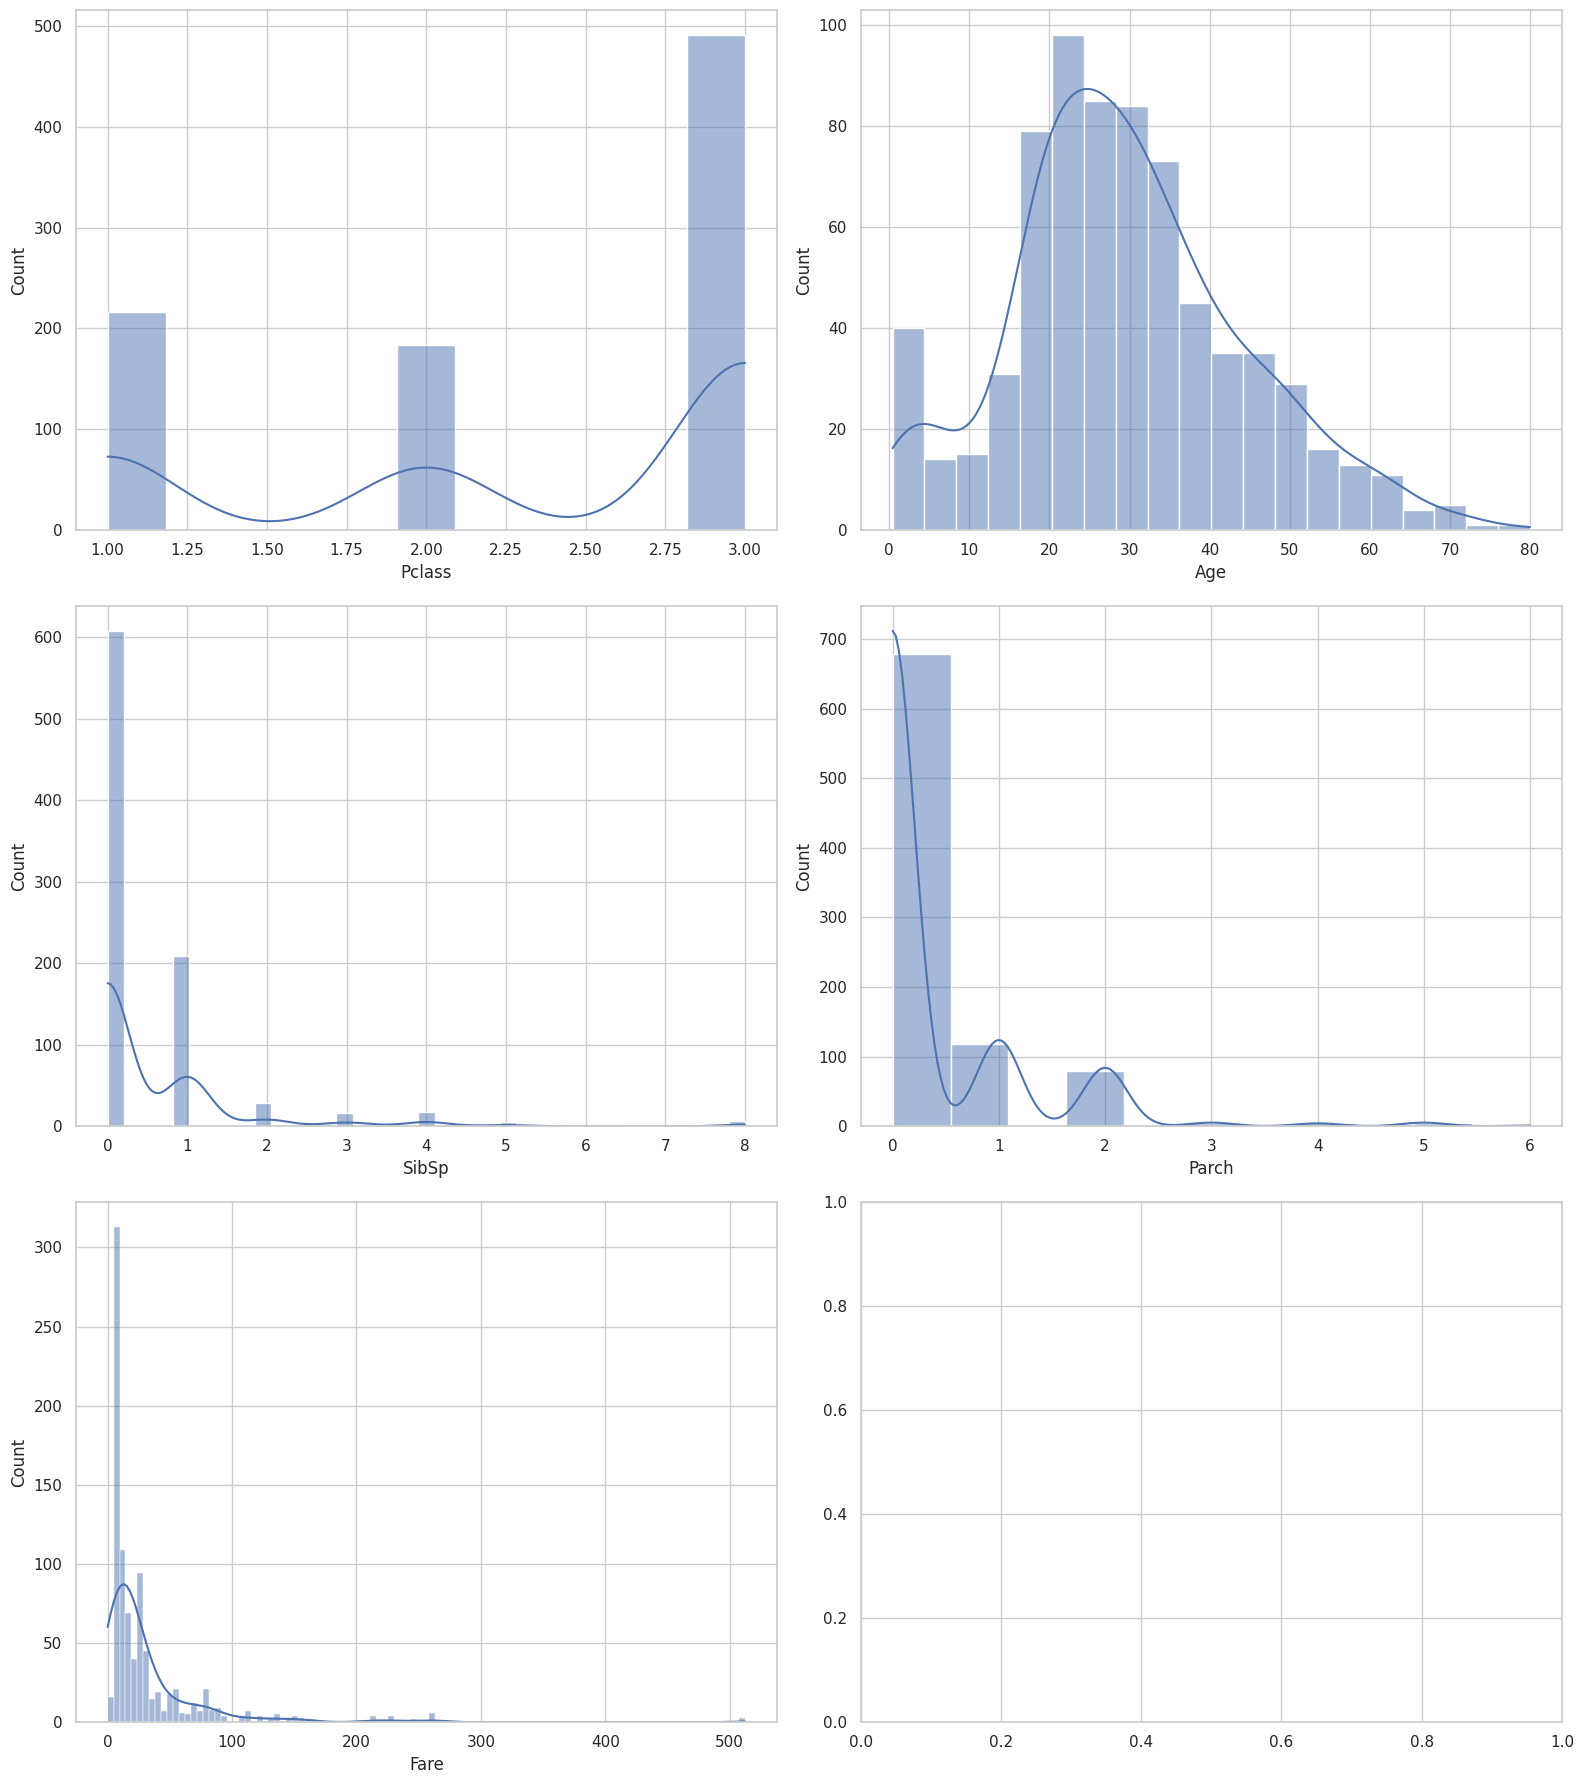

In [27]:
sns.set(style="whitegrid")

rows = (len(numerical_features) + 1) // 2
cols = 2
_, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(8 * cols, 6 * rows))

for i, feature_name in enumerate(numerical_features):
    row_idx, col_idx = divmod(i, cols)
    sns.histplot(data=train, x=feature_name, kde=True, ax=axes[row_idx, col_idx])

plt.tight_layout()

plt.show()

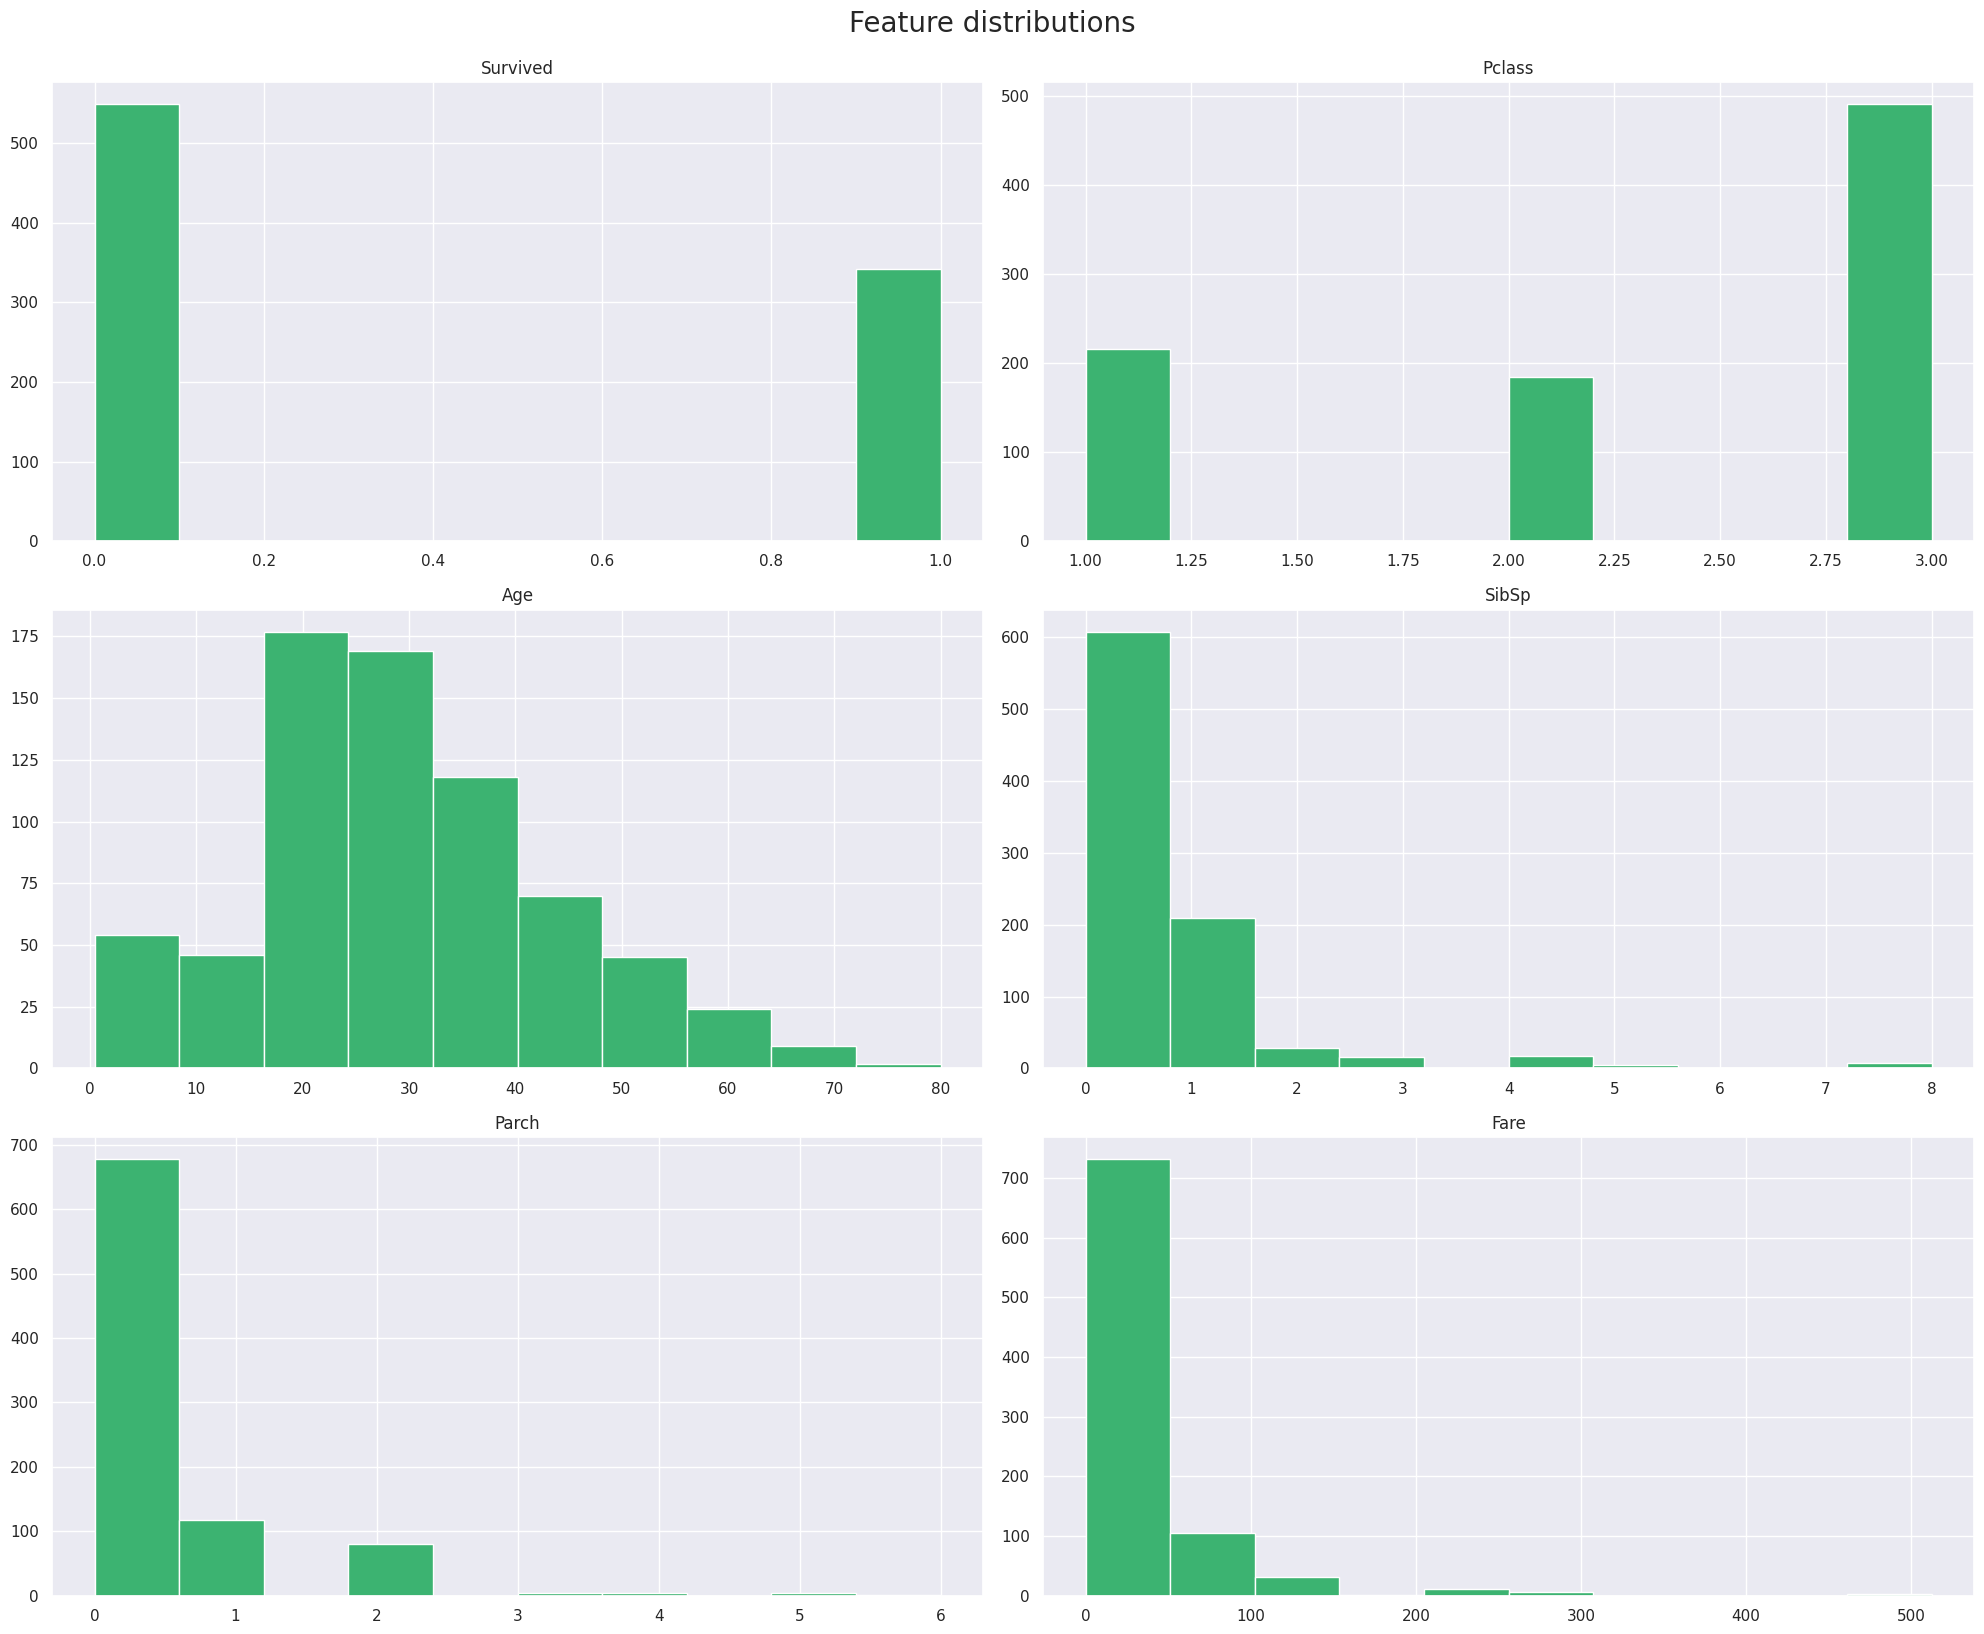

In [28]:
sns.set(rc={'figure.figsize': (20, 16)})
train.hist(color='mediumseagreen')
plt.tight_layout()
plt.suptitle('Feature distributions', y=1.02, fontsize=20)
plt.show()

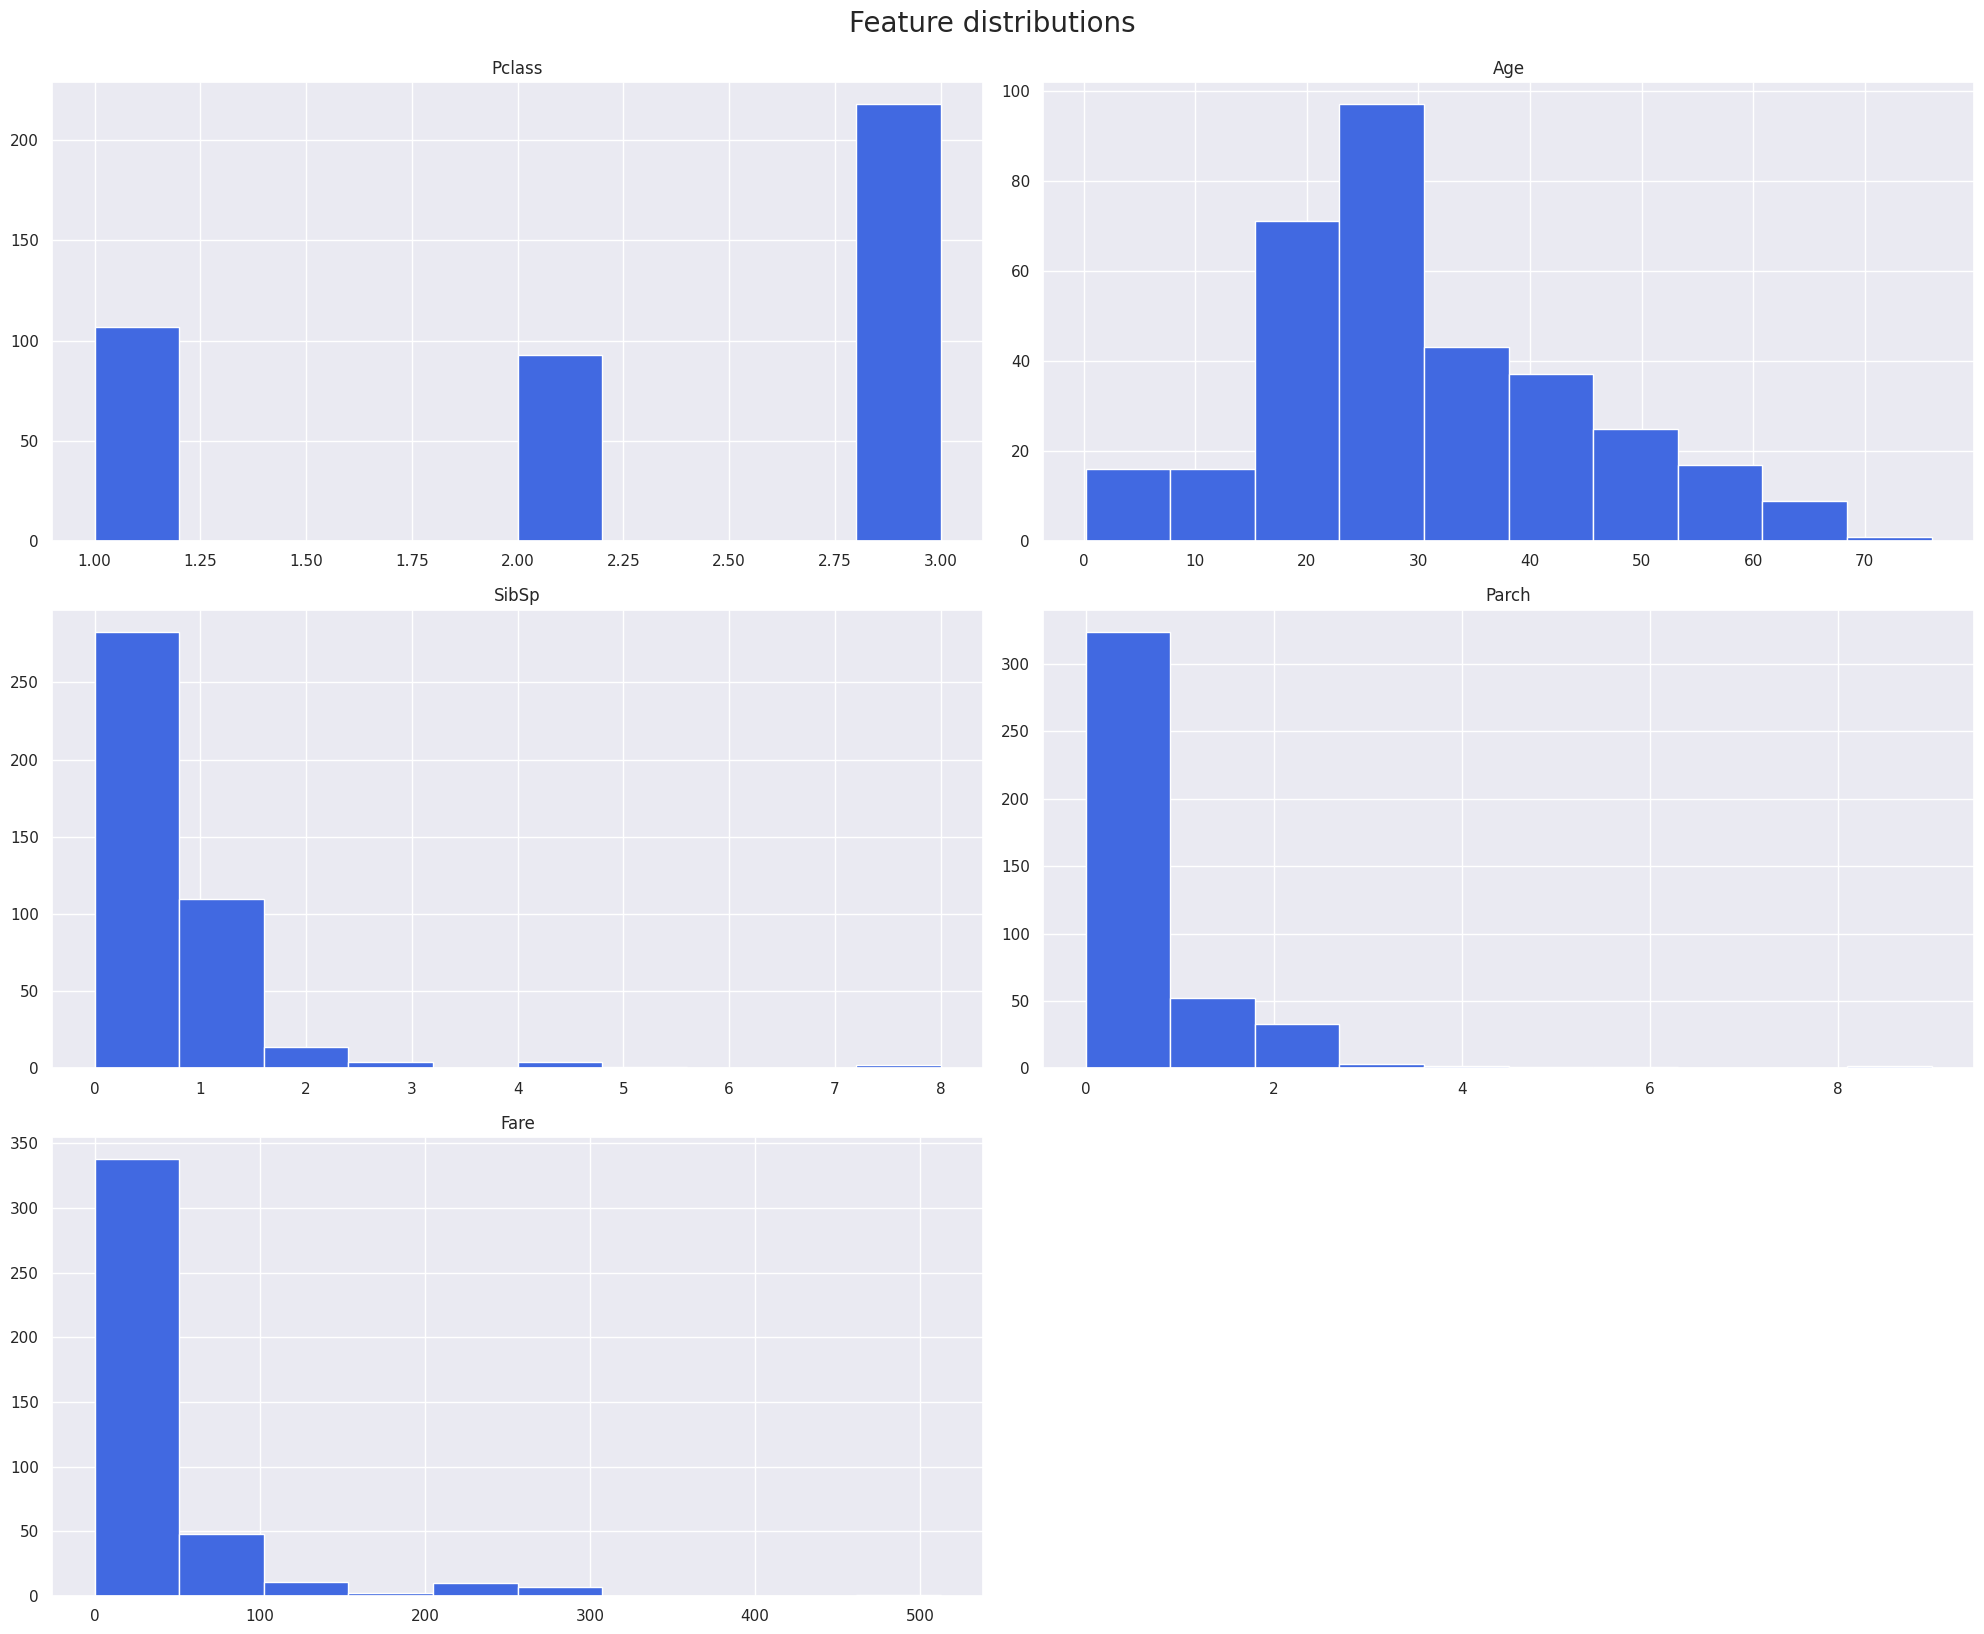

In [29]:
sns.set(rc={'figure.figsize': (20, 16)})
test.hist(color='royalblue')
plt.tight_layout()
plt.suptitle('Feature distributions', y=1.02, fontsize=20)
plt.show()

#### データの分布を可視化する

##### 数値型の説明変数の分布

カーネル密度推定（KDE: Kernel Density Estimation）
- 実データから、正規分布曲線のように下部の面積が1となるような連続した曲線（確率密度関数）を推定する

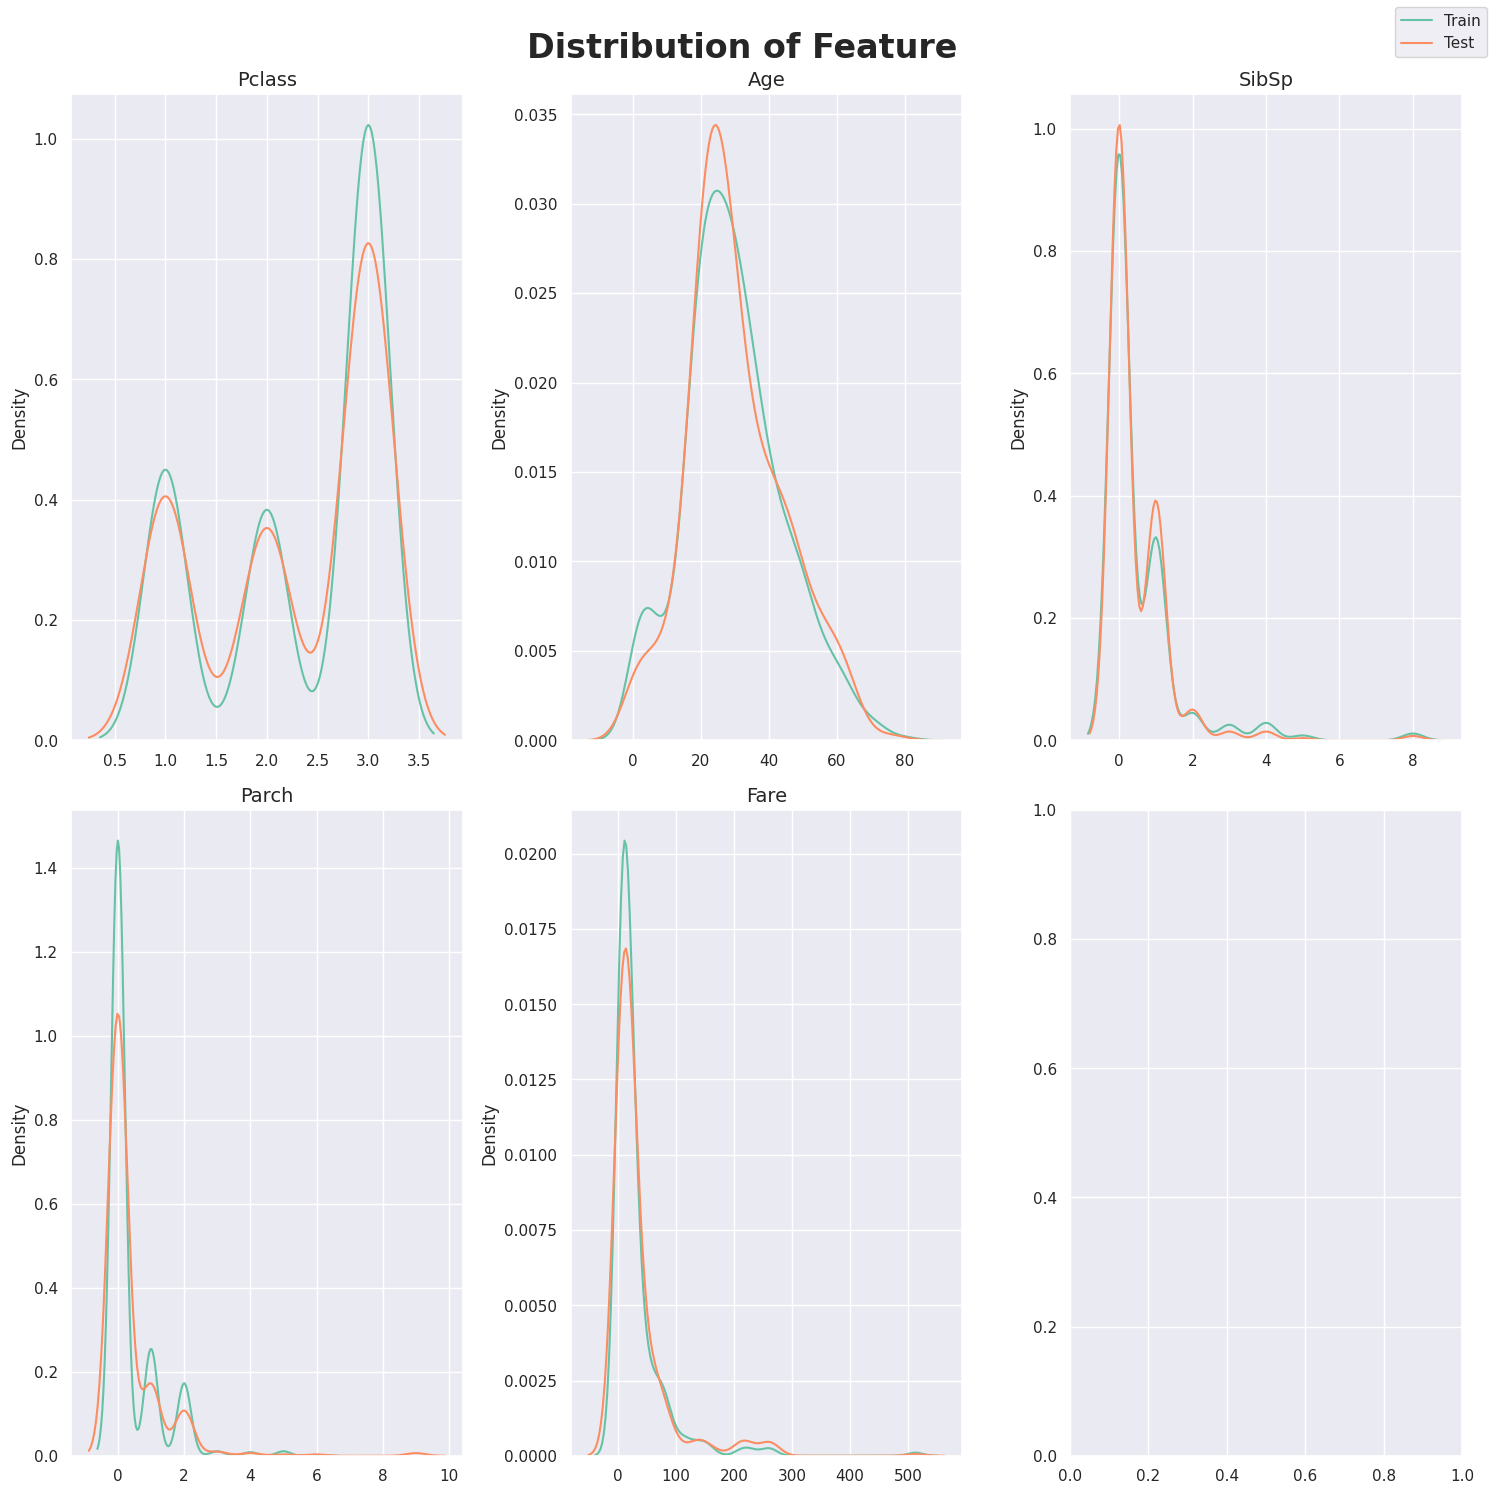

In [30]:
fig, ax = plt.subplots(2, 3, figsize=(15, 15))
ax = ax.flatten()
pal2 = sns.color_palette("Set2")
for i, column in enumerate(numerical_features):
    sns.kdeplot(train[column], ax=ax[i], color=pal2[0])
    sns.kdeplot(test[column], ax=ax[i], color=pal2[1], warn_singular=False)

    ax[i].set_title(f'{column}', size=14)
    ax[i].set_xlabel(None)

fig.suptitle('Distribution of Feature', fontsize=24, fontweight='bold')
fig.legend(['Train', 'Test'])
plt.tight_layout()

#### Adversarial Validation(敵対性の検証)

- Adversarial Validation(敵対性の検証)の目的
    - 訓練用のデータセットとテスト用データセットの間で値の分布に差があるかないかを検証すること
- もしもしこの検証の結果得られるROC-AUCスコアが0.5に近いようなら、二つのデータセットは同じ分布を持っていると考えていい
    - しかしその値が0.5から離れているようなら、分布が同様とは言えない

- 信頼できるCV（Cross-validation）スコアは同様の分布を持つデータセットからのみ取得されるため、あらかじめCVスコアが信頼できることを確認しておくためこの検証が必要

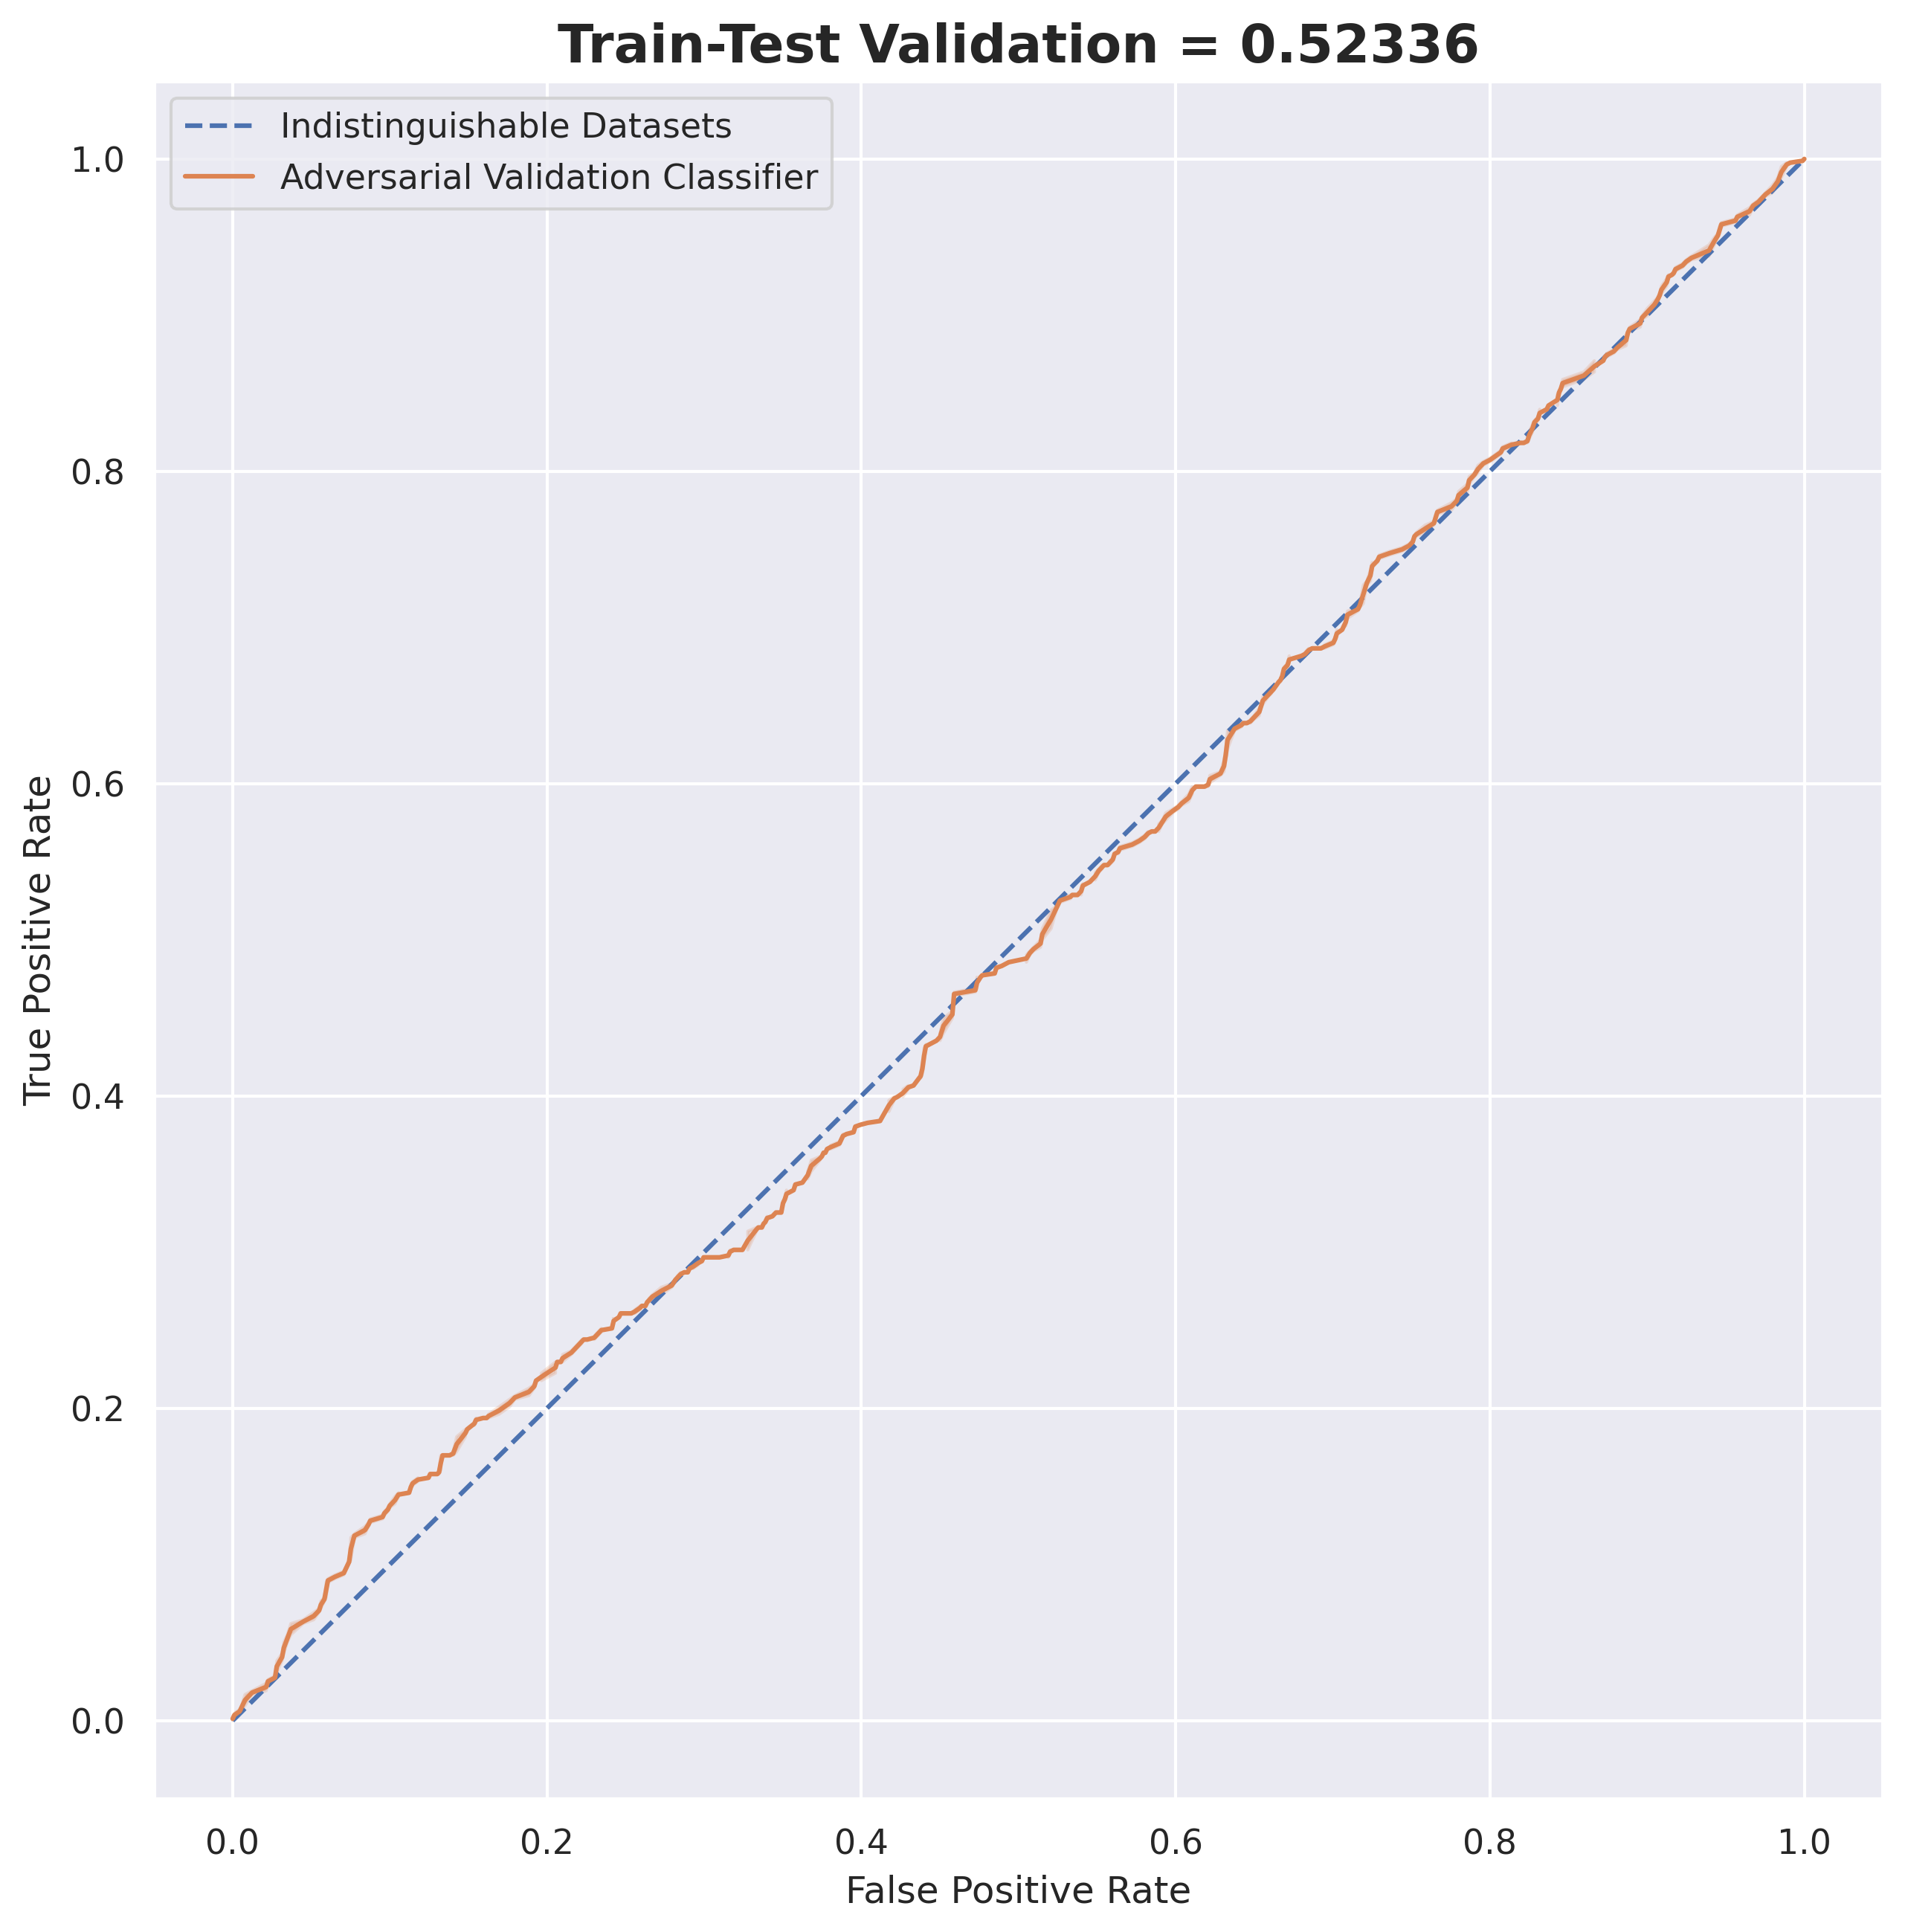

In [31]:
def adversarial_validation(dataset_1=train, dataset_2 = test, label='Train-Test'):
    adv_train = dataset_1.drop('Survived', axis=1) # 目的変数を指定する
    adv_test = dataset_2.copy()

    adv_train['is_test'] = 0
    adv_test['is_test'] = 1

    adv = pd.concat([adv_train, adv_test], ignore_index=True)
    adv_shuffled = adv.sample(frac=1)
    adv_X = adv_shuffled.drop('is_test', axis=1)
    adv_y = adv_shuffled.is_test

    skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
    val_scores = []
    predictions = np.zeros(len(adv))

    for fold, (train_idx, val_idx) in enumerate(skf.split(adv_X, adv_y)):
        adv_lr = make_pipeline(OneHotEncoder(cols=categorical_features), XGBClassifier(random_state=42))
        adv_lr.fit(adv_X.iloc[train_idx], adv_y.iloc[train_idx])

        val_preds = adv_lr.predict_proba(adv_X.iloc[val_idx])[:, 1]
        predictions[val_idx] = val_preds
        val_score = roc_auc_score(adv_y.iloc[val_idx], val_preds)
        val_scores.append(val_score)

    fpr, tpr, _ = roc_curve(adv['is_test'], predictions)

    plt.figure(figsize=(10, 10), dpi=300)
    sns.lineplot(x=[0, 1], y=[0, 1], linestyle="--", label="Indistinguishable Datasets")
    sns.lineplot(x=fpr, y=tpr, label="Adversarial Validation Classifier")
    plt.title(f'{label} Validation = {np.mean(val_scores):.5f}', weight='bold', size=17)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

adversarial_validation()

なんとも言えない分布の差

### 円グラフと棒グラフ（目的変数）

Survived
0    549
1    342
Name: count, dtype: int64


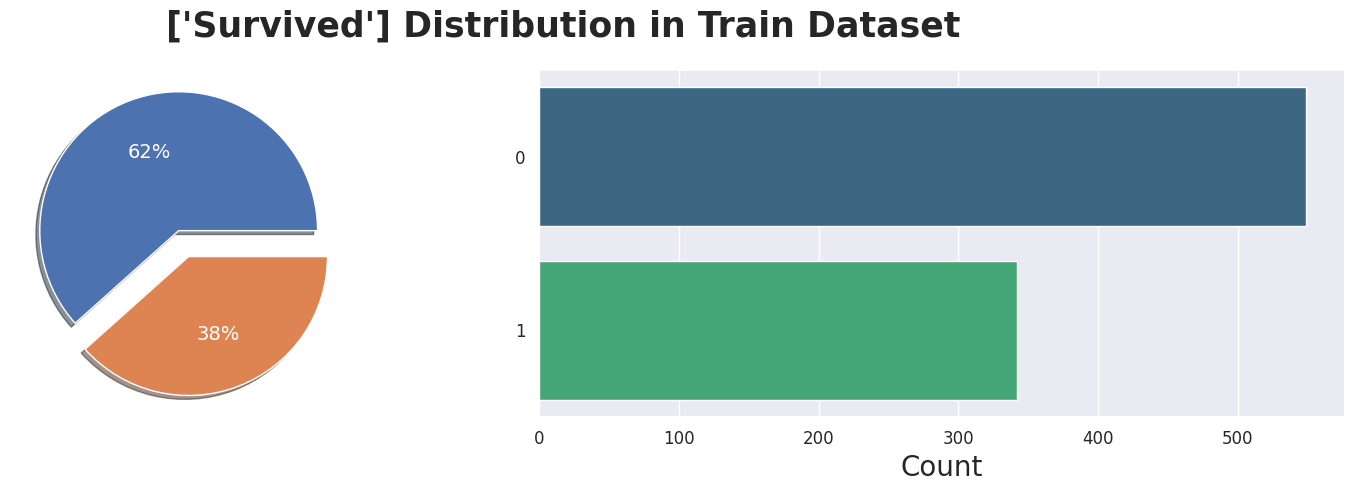

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
ax = ax.flatten()

ax[0].pie(
    target.value_counts(),
    shadow=True,
    explode=[.1 for i in range(target.nunique())],
    autopct='%1.f%%',
    textprops={'size': 14, 'color':'white'}
)

sns.countplot(data=train, y=target, ax=ax[1], palette='viridis', order=target.value_counts().index)
ax[1].yaxis.label.set_size(20)
plt.yticks(fontsize=12)
ax[1].set_xlabel('Count', fontsize=20)
ax[1].set_ylabel(None)
plt.xticks(fontsize=12)

fig.suptitle(target_name + ' Distribution in Train Dataset', fontsize=25, fontweight='bold')
plt.tight_layout()

# 目的変数を数える
print(f'{target.value_counts()}')

### 箱ひげ図

数値型の説明変数

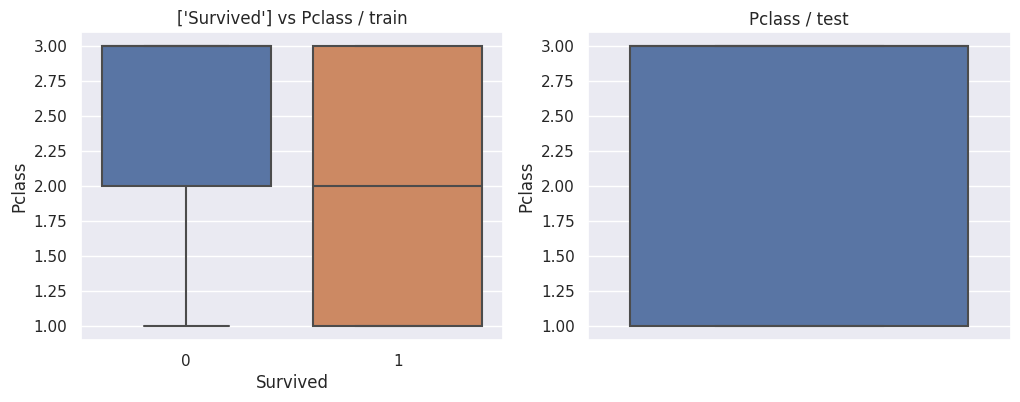

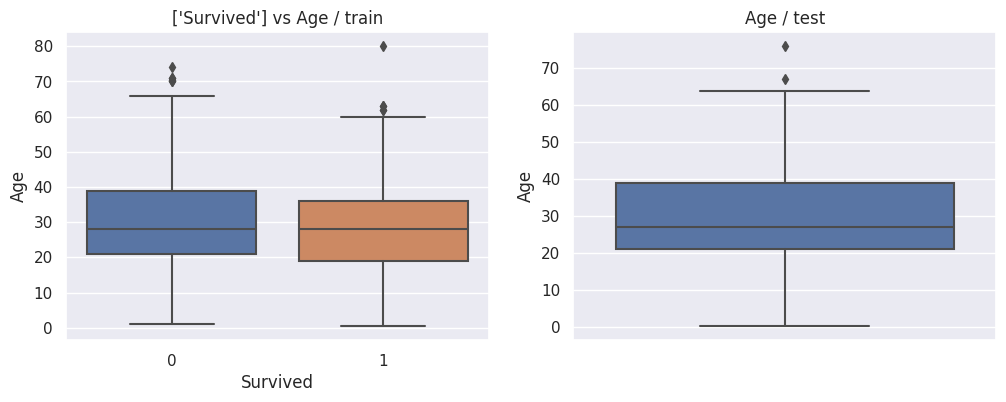

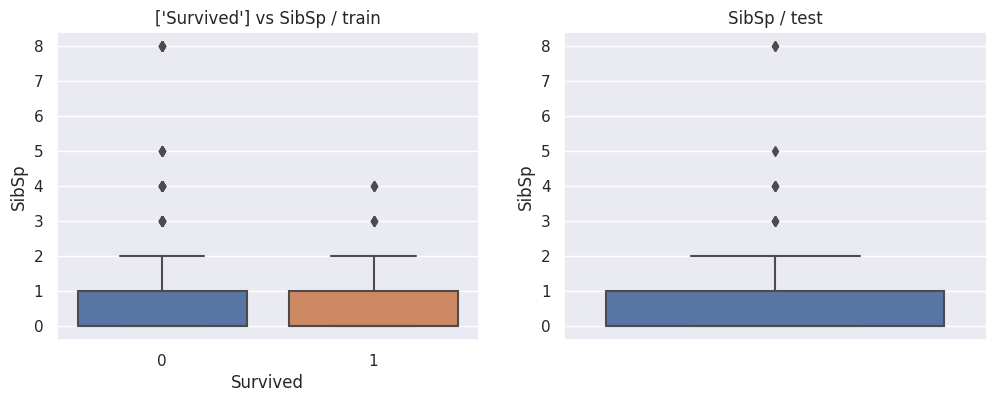

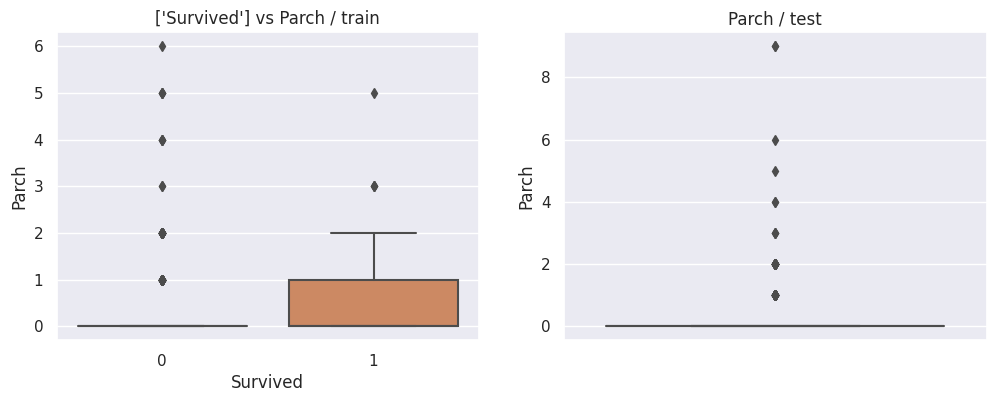

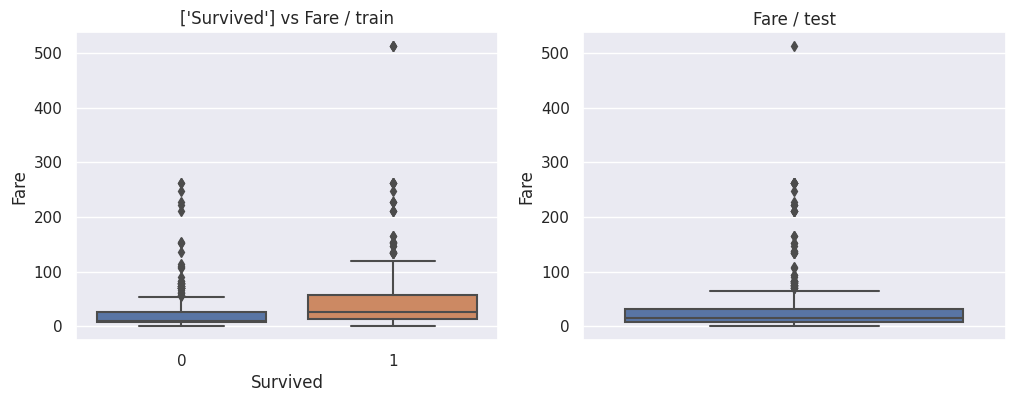

In [33]:
for feat in numerical_features:
    plt.figure(figsize=(12, 4))
    ax1 = plt.subplot(1, 2, 1)
    sns.boxplot(data=train, x=target, y=feat)
    plt.title(target_name + ' vs ' + feat + ' / train')
    x1 = plt.subplot(1, 2, 2)
    sns.boxplot(data=test, y=feat)
    plt.title(feat + ' / test')
    plt.show()

In [34]:
df_melted = pd.melt(train.select_dtypes(include=['float', 'int']))

custom_colors = px.colors.qualitative.Plotly

fig = px.box(df_melted, x='variable', y='value', color='variable', color_discrete_sequence=custom_colors)
fig.update_layout(title='Box Plots')
fig.show()

#### 箱ひげ図（目的変数）

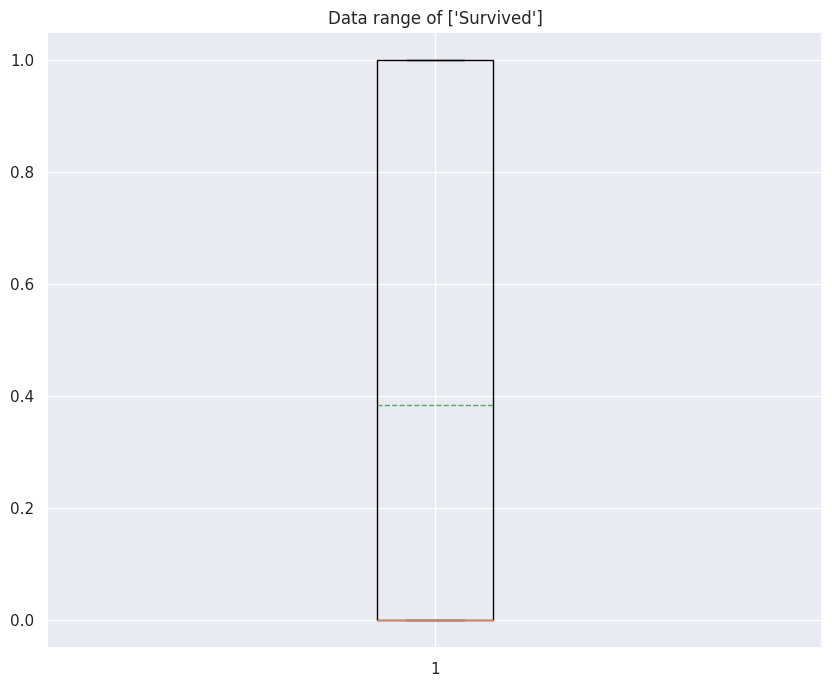

In [35]:
# データの範囲を調べる
plt.figure(figsize=(10, 8))
plt.boxplot(target, showmeans=True, meanline=True)
plt.title('Data range of ' + target_name)
plt.grid(True)

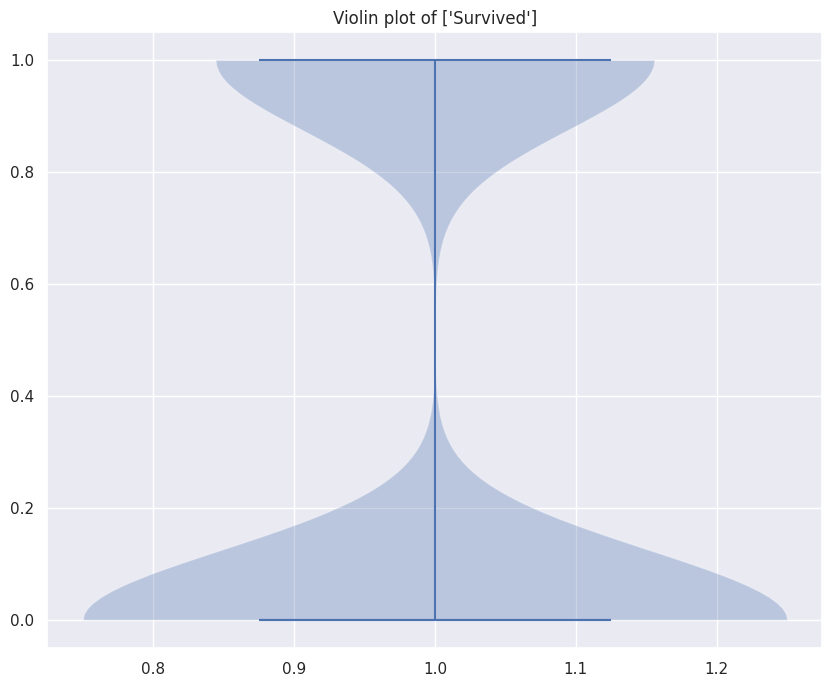

In [36]:
# バイオリンプロット
plt.figure(figsize=(10, 8))
plt.violinplot(target, showmedians=True) # 中央値をマーキングする
plt.title('Violin plot of ' + target_name)
plt.grid(True)

### 相関（ヒートマップ）

<Axes: >

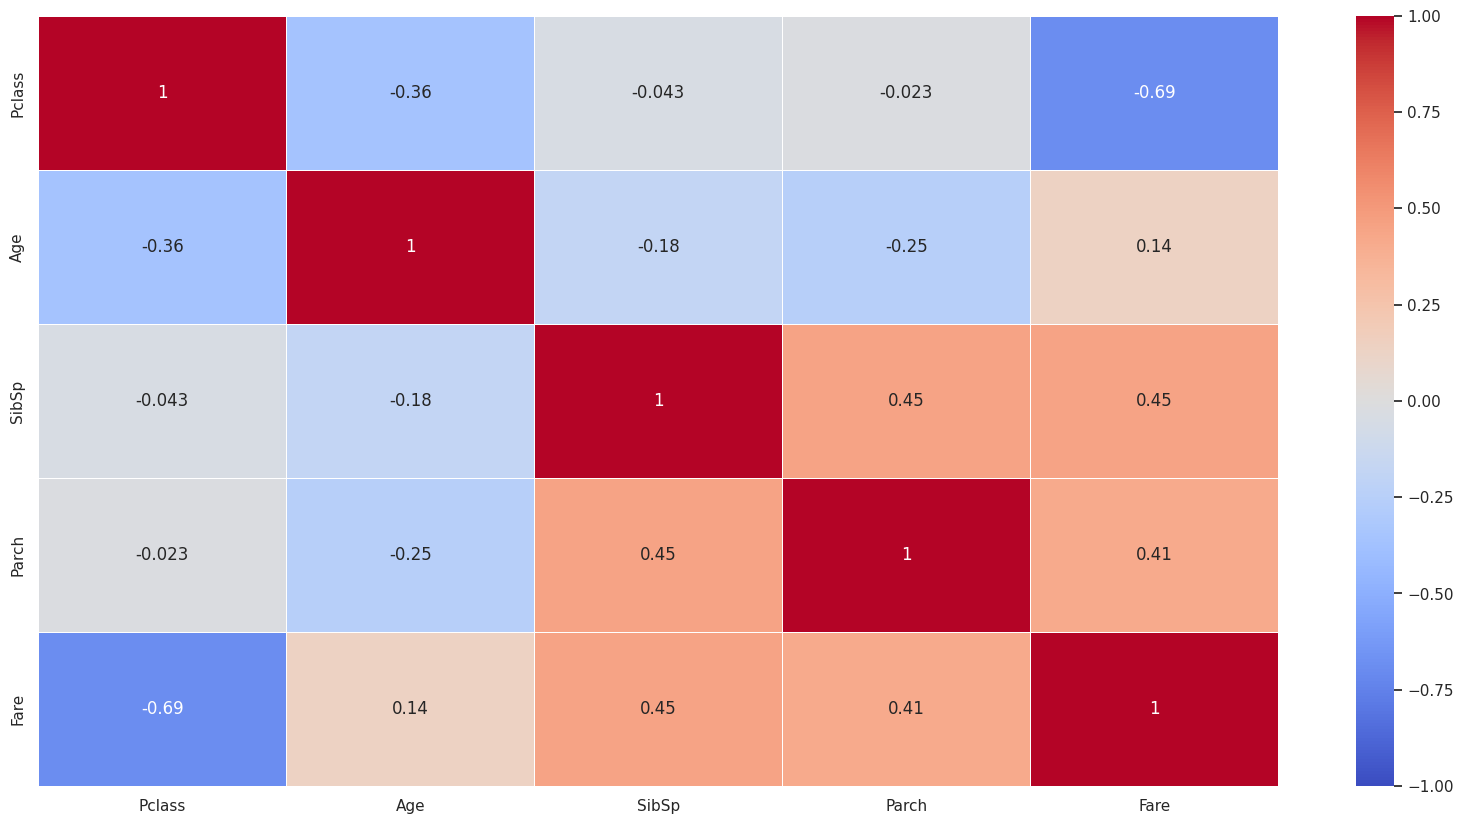

In [37]:
corr = train[numerical_features].corr(method='spearman')
plt.figure(figsize=(20, 10))
sns.heatmap(corr, linewidth=0.5, square=False, annot=True, cmap="coolwarm", vmin=-1, vmax=1)

#### 相関(目的変数)

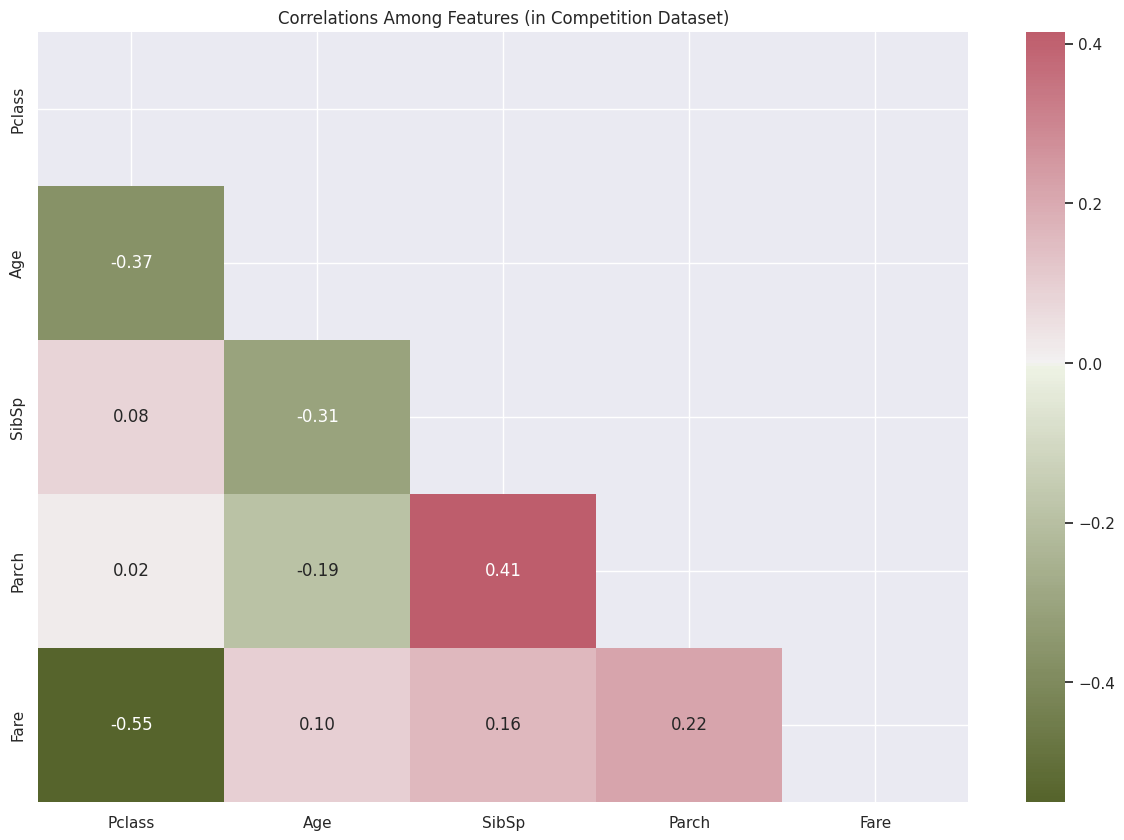

In [38]:
corr_mat_data = train[numerical_features].corr()
data_mask = np.triu(np.ones_like(corr_mat_data, dtype=bool))

cmap = sns.diverging_palette(100, 7, s=75, l=40, n=5, center='light', as_cmap=True)

plt.figure(figsize=(15, 10))
sns.heatmap(corr_mat_data, annot=True, cmap=cmap, fmt='.2f', center=0,
            annot_kws={'size': 12}, mask=data_mask).set_title('Correlations Among Features (in Competition Dataset)');

#### 階層的クラスタリング

- 特徴間の関係の強さと方向性を調べる
- 特徴をクラスタリングする

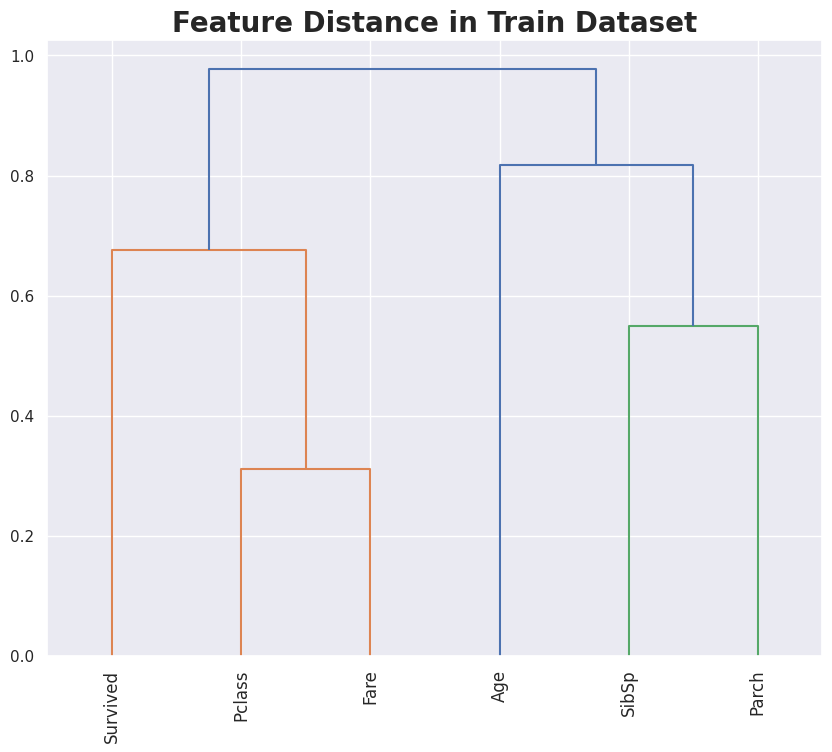

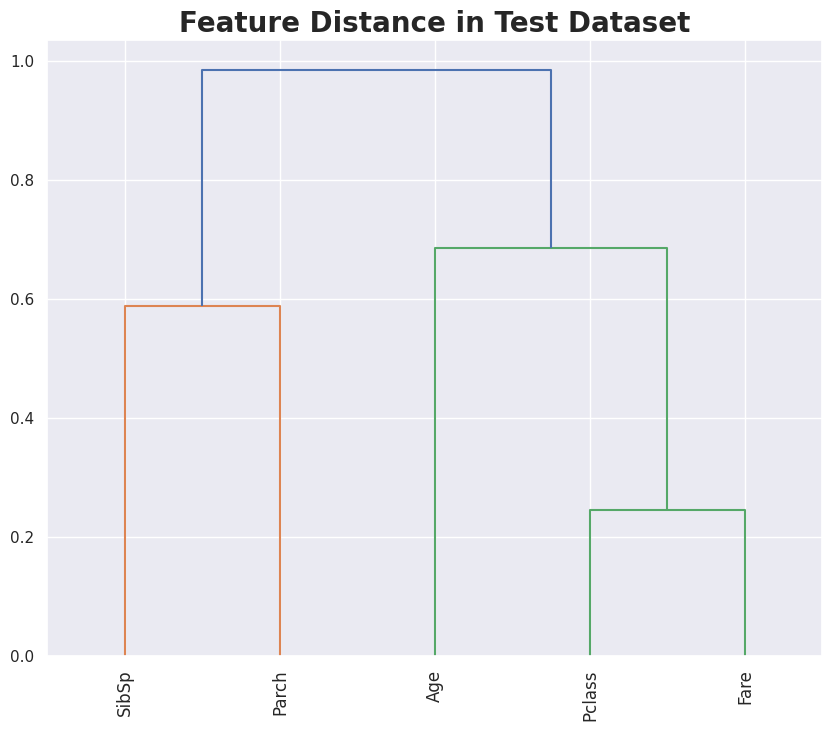

In [39]:
def distance(data, label = ''):
    corr = data.corr(method='spearman')
    dist_linkage = linkage(squareform(1 - abs(corr)), 'complete')

    plt.figure(figsize=(10, 8))
    dendro = dendrogram(dist_linkage, labels=data.columns, leaf_rotation=90)
    plt.title(f'Feature Distance in {label} Dataset', weight='bold', size=20)
    plt.show()

distance(train._get_numeric_data(), 'Train')
distance(test._get_numeric_data(), 'Test')

## 目的変数

In [40]:
print(target_name +' Class labels:', np.unique(target))

['Survived'] Class labels: [0 1]


* **得られた情報**
    - 概要
			- 評価指標
    - データの構成
    - データ数・型
    - カラム名・数
- EDA
    - 要約統計量
    - 欠損値
    - 尖度・歪度
    - 分布
        * 密度関数
            
        * 円グラフ
				* ヒストグラム
        * 箱ひげ図
        
        * 相関（ヒートマップ）
				* 散布図
    - 目的変数

## EDAの可視化するためのライブラリ

### sweetviz

In [41]:
report = sv.compare([train, "Train"], [test, "Test"], target_feat='Survived') # 目的変数を指定する
report.show_html(OUTPUT_DIR + "/EDA_sweetviz.html")

                                             |          | [  0%]   00:00 -> (? left)

Report /kaggle/working//EDA_sweetviz.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


## 実行時間を調べるために使う

In [42]:
end_time = time.time()
lap = end_time - start_time
indi_time = changeHMS(lap)
indi_time

'47s'